# 형태소분석기 비교

In [3]:
from konlpy.tag import Kkma, Komoran, Okt
from mecab import MeCab
from konlp.kma.klt2023 import klt2023

mec = MeCab()
okt = Okt()
kkm = Kkma()
kom = Komoran()
klt = klt2023()

## 정확도 비교

In [3]:
txt = '내 나이와 같은 영화를 지금 본 나는 감동적이다..하지만 훗날 다시보면대사하나하나 그 감정을완벽하게 이해할것만 같다...'

print(txt)
print(f'mec: {mec.nouns(txt)}') #mecab
print(f'kom: {kom.nouns(txt)}') #komoran
print(f'kkm: {kkm.nouns(txt)}') #kkma
print(f'okt: {okt.nouns(txt)}') #okt
print(f'klt: {klt.nouns(txt)}') #klt

내 나이와 같은 영화를 지금 본 나는 감동적이다..하지만 훗날 다시보면대사하나하나 그 감정을완벽하게 이해할것만 같다...
mec: ['내', '나이', '영화', '나', '감동', '훗날', '보면대', '사', '하나', '하나', '감정', '완벽', '이해', '것']
kom: ['나이', '영화', '감동', '하지', '훗날', '다시', '보면', '대사', '하나하나', '감정', '을', '완벽', '이해', '것']
kkm: ['내', '나이', '영화', '나', '감동적', '훗날', '대사', '대사하나하나', '하나하나', '감정', '완벽', '이해']
okt: ['내', '나이', '영화', '지금', '나', '감동', '훗날', '다시', '사하나', '그', '감정', '이해']
klt: ['나', '나이', '영화', '나', '감동적', '훗날', '다시보면대사하나', '감정을완벽', '이해할것']


In [4]:
txt = '이거어렸을때되게재밌게봄ㅋㅋ이정재 이범수ㅋㅋㅋㅋ연기쩜'

print(txt)
print(f'mec: {mec.nouns(txt)}') #mecab
print(f'kom: {kom.nouns(txt)}') #komoran
print(f'kkm: {kkm.nouns(txt)}') #kkma
print(f'okt: {okt.nouns(txt)}') #okt
print(f'klt: {klt.nouns(txt)}') #klt

이거어렸을때되게재밌게봄ㅋㅋ이정재 이범수ㅋㅋㅋㅋ연기쩜
mec: ['이거', '때', '이정재', '이범수', '연기']
kom: []
kkm: ['이거', '때', '봄', '이정재', '이', '이범수', '범수', '연기']
okt: ['거', '때', '봄', '이정재', '이범수', '연기', '쩜']
klt: ['이거어렸을때되게재밌게봄', '이정', '이범수', '연기쩜']


> Komoran은 띄어쓰기가 잘 되어있지 않은 문장에 대해서 형태소 분석 성능이 떨어짐

## 속도 비교

In [43]:
import pandas as pd
ratings = pd.read_csv('/home/kyuyeon/data/nsmc/ratings.txt', sep='\t')
ratings.head(3)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1


100%|██████████| 10000/10000 [00:08<00:00, 1159.35it/s]


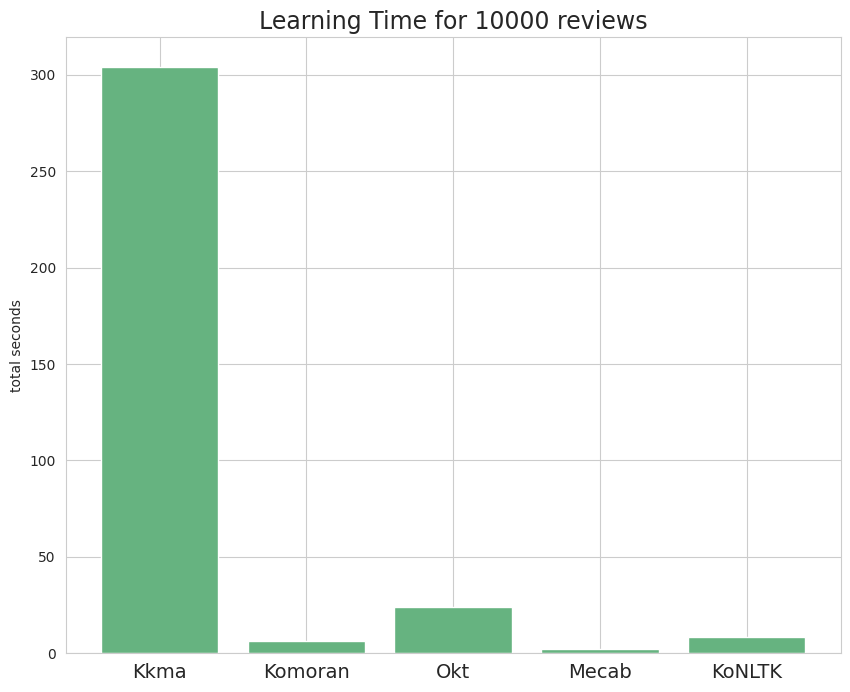

In [45]:
import time
from tqdm import tqdm

def tagger_time(tagger, texts):
  time_sum = 0

  for sentence in tqdm(texts):
    t1 = time.time()
    try:
      tagger.nouns(sentence)
    except:
      pass
    t2 = time.time()

    time_sum += (t2 - t1)

  return time_sum
texts = ratings['document'][:10000]
time_list = []

for tagger in [kkm, kom, okt, mec, klt]:
  time_list.append(tagger_time(tagger, texts))
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

tagger = ['Kkma', 'Komoran', 'Okt', 'Mecab', 'KoNLTK']

plt.figure(figsize=(10,8))
plt.bar(tagger, time_list, color=(0.4,0.7,0.5))
plt.title('Learning Time for 10000 reviews', fontsize=17)
plt.xticks(fontsize=14)
plt.ylabel('total seconds')
plt.savefig('/home/kyuyeon/문서/kmu/23-1/bigdata-latest/movie/speed.png', dpi=300)

> Kkma는 속도 측면에서 성능이 매우 떨어짐

#### references

https://soohee410.github.io/compare_tagger

> 속도 측면에서 Mecab 우수  
정규화 측면에서 Okt 우수  
두 가지 형태소 분석기에 대해서 실험 진행  

---

# 전처리 및 토큰화

In [1]:
# 불용어 리스트 로드
korean_stopwords_path = '/home/kyuyeon/data/stopwords.txt'

# 텍스트 파일을 오픈합니다.
with open(korean_stopwords_path, encoding='utf-8') as f:
	stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

In [119]:
import re

def get_tokens(tagger, text):
    text = re.sub(pattern=r'[^a-zA-Z0-9가-힣 \n]', repl='', string=str(text), flags=re.I)
    tokens = []
    try:
        tokens += tagger.nouns(text)
    except:
        pass
    tokens = [token for token in tokens if token not in stopwords]
    return tokens

In [128]:
import pandas as pd
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())

def preprocessing(tagger):
    df = pd.read_csv('/home/kyuyeon/data/nsmc/ratings.txt', sep='\t')
    df['tokens'] = df['document'].progress_apply(lambda sentence: get_tokens(tagger, sentence))
    df.to_csv('/home/kyuyeon/문서/kmu/23-1/bigdata-latest/movie/data/ratings-' + str(tagger).replace('<', '').split('.')[0] + '.csv', sep=',', index=False)


0it [06:10, ?it/s]


In [129]:
for tagger in [okt, mec]:
    preprocessing(tagger)

200000it [01:02, 3203.12it/s]


In [4]:
df = pd.read_csv('/home/kyuyeon/문서/kmu/23-1/bigdata-latest/movie/data/ratings-okt.csv')
df.head(8)

,id,document,label,tokens
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,['보고']
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1,"['디자인', '학생', '외국', '디자이너', '일군', '전통', '통해', ..."
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1,"['폴리스스토리', '시리즈', '부터', '뉴', '최고']"
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1,"['연기', '진짜', '몰입', '다그', '진짜', '영화']"
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1,"['안개', '밤하늘', '초승달', '영화']"
5,2190435,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1,"['사랑', '라면', '처음', '끝', '영화']"
6,9279041,완전 감동입니다 다시봐도 감동,1,"['완전', '감동', '감동']"
7,7865729,개들의 전쟁2 나오나요? 나오면 1빠로 보고 싶음,1,"['전쟁', '빠']"


In [24]:
type(df['label'][1])

numpy.int64

---

# 키워드 분석

In [1]:
ratings_okt = '/home/kyuyeon/문서/kmu/23-1/bigdata-latest/movie/data/ratings-okt.csv'
ratings_mec = '/home/kyuyeon/문서/kmu/23-1/bigdata-latest/movie/data/ratings-mec.csv'

## Word Count

In [2]:
from collections import Counter
import pandas as pd
import ast

def word_counter(filename):
    # Read CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Evaluate 'tokens' column using ast.literal_eval
    df['tokens'] = df['tokens'].apply(ast.literal_eval)
    
    # Combine the lists in the 'tokens' column into one list
    combined_list = [item for sublist in df['tokens'] for item in sublist]
    
    # Count occurrences of words using Counter
    counts = Counter(combined_list)
    
    return counts

In [3]:
okt_count = word_counter(ratings_okt)
mec_count = word_counter(ratings_mec)

In [4]:
print(f'counter of okt: {okt_count.most_common(10)}')
print(f'counter of mec: {mec_count.most_common(10)}')

counter of okt: [('영화', 57883), ('정말', 11748), ('진짜', 10643), ('평점', 8394), ('최고', 7805), ('연기', 7047), ('스토리', 6734), ('이영화', 6516), ('감동', 6341), ('드라마', 6268)]
counter of mec: [('영화', 75236), ('거', 9835), ('연기', 8901), ('최고', 8586), ('평점', 8238), ('스토리', 7020), ('드라마', 6703), ('게', 6551), ('듯', 6519), ('감동', 6309)]


In [5]:
# 한 글자 키워드를 제거합니다.
okt_count = Counter({x : okt_count[x] for x in okt_count if len(x) > 1})
mec_count = Counter({x : mec_count[x] for x in mec_count if len(x) > 1})

print(f'counter of okt: {okt_count.most_common(10)}')
print(f'counter of mec: {mec_count.most_common(10)}')

counter of okt: [('영화', 57883), ('정말', 11748), ('진짜', 10643), ('평점', 8394), ('최고', 7805), ('연기', 7047), ('스토리', 6734), ('이영화', 6516), ('감동', 6341), ('드라마', 6268)]
counter of mec: [('영화', 75236), ('연기', 8901), ('최고', 8586), ('평점', 8238), ('스토리', 7020), ('드라마', 6703), ('감동', 6309), ('배우', 5643), ('내용', 5602), ('감독', 5550)]


## WordCloud

In [6]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def wordcloud(count, tagger):
    wc = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # 사용할 폰트
        background_color='white', # 배경색
        max_words=100, # 최대 빈도수를 기준으로 출력할 단어 수
        max_font_size=70, # 최대 폰트 크기
        colormap='hsv' # 컬러 스타일 ex)'Accent', 'Accent_r', 'Blues', 'Blues_r' 등등
    ).generate_from_frequencies(dict(count))
    wc.to_file('/home/kyuyeon/문서/kmu/23-1/bigdata-latest/movie/wordcloud/wordcloud-' + tagger + '.png')

    plt.figure()
    plt.axis('off')
    plt.imshow(wc, interpolation='bilinear') 
    plt.show()

### 형태소분석기 별 키워드 분석

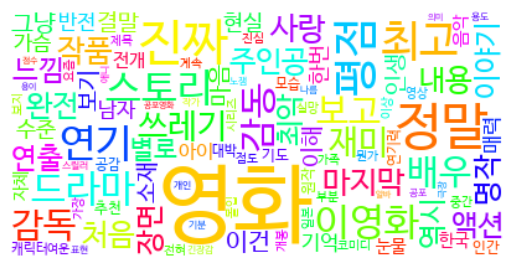

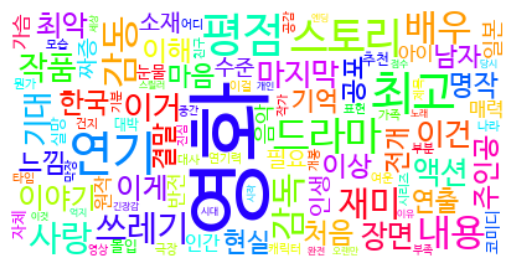

In [9]:
for count, tagger in zip([okt_count, mec_count], ['okt', 'mec']):
    wordcloud(count, tagger)

In [10]:
okt_total = 0
mec_total = 0

for key, value in okt_count.items():
    okt_total += value
for key, value in mec_count.items():
    mec_total += value

print(f'total of okt: {okt_total}')
print(f'total of mec: {mec_total}')

total of okt: 855799
total of mec: 751580


In [11]:
# 2가지 토크나이저의 키워드 별 비율 합치기, (해당 키워드 빈도수) / (전체 키워드 수)
okt_count = Counter({x: (okt_count[x]/okt_total)*10000 for x in okt_count})
mec_count = Counter({x: (mec_count[x]/mec_total)*10000 for x in mec_count})

print(f'counter of okt: {okt_count.most_common(10)}')
print(f'counter of mec: {mec_count.most_common(10)}')

counter of okt: [('영화', 676.3620896962955), ('정말', 137.27522467308327), ('진짜', 124.3633142829099), ('평점', 98.08377901820405), ('최고', 91.20132180570438), ('연기', 82.34410182764879), ('스토리', 78.68670096599784), ('이영화', 76.13937384829849), ('감동', 74.09450116207194), ('드라마', 73.241497127246)]
counter of mec: [('영화', 1001.0378136725299), ('연기', 118.43050639985098), ('최고', 114.23933579924957), ('평점', 109.60909018334708), ('스토리', 93.40323052768834), ('드라마', 89.18544932009898), ('감동', 83.94315974347374), ('배우', 75.08182761648793), ('내용', 74.53631017323505), ('감독', 73.84443439154848)]


In [12]:
set_count = okt_count + mec_count

print(f'counter of set: {set_count.most_common(10)}')

counter of set: [('영화', 1677.3999033688253), ('평점', 207.69286920155113), ('최고', 205.44065760495397), ('연기', 200.77460822749975), ('스토리', 172.08993149368618), ('드라마', 162.426946447345), ('감동', 158.0376609055457), ('배우', 138.65984067796614), ('정말', 137.67438377790245), ('감독', 135.16724500478827)]


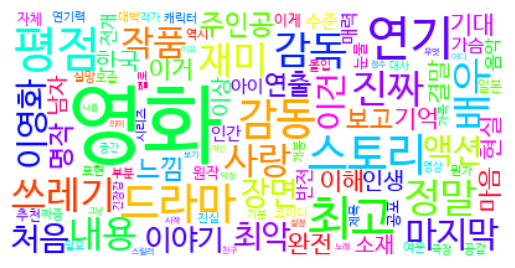

In [13]:
wordcloud(set_count, 'set')

### 라벨 별 키워드 분석

In [8]:
from collections import Counter
import pandas as pd
import ast

def label_counter(filename, label):
    # Read CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Evaluate 'tokens' column using ast.literal_eval
    df['tokens'] = df['tokens'].apply(ast.literal_eval)
    
    # Filter rows where 'label' is not equal to 1
    df = df[df['label'] == label]
    
    # Combine the lists in the 'tokens' column into one list
    combined_list = [item for sublist in df['tokens'] for item in sublist]
    
    # Count occurrences of words using Counter
    counts = Counter(combined_list)
    
    return counts

In [9]:
okt_count_1 = label_counter(ratings_okt, 1)
okt_count_0 = label_counter(ratings_okt, 0)
mec_count_1 = label_counter(ratings_mec, 1)
mec_count_0 = label_counter(ratings_mec, 0)

# 한 글자 키워드를 제거합니다.
okt_count_1 = Counter({x : okt_count_1[x] for x in okt_count_1 if len(x) > 1})
okt_count_0 = Counter({x : okt_count_0[x] for x in okt_count_0 if len(x) > 1})
mec_count_1 = Counter({x : mec_count_1[x] for x in mec_count_1 if len(x) > 1})
mec_count_0 = Counter({x : mec_count_0[x] for x in mec_count_0 if len(x) > 1})

print('-----------------------True--------------------------')
print(f'counter of okt 1: {okt_count_1.most_common(10)}')
print(f'counter of mec 1: {mec_count_1.most_common(10)}')
print('-----------------------False-------------------------')
print(f'counter of okt 0: {okt_count_0.most_common(10)}')
print(f'counter of mec 0: {mec_count_0.most_common(10)}')

-----------------------True--------------------------
counter of okt 1: [('영화', 29652), ('정말', 7832), ('최고', 7220), ('진짜', 5181), ('감동', 5018), ('연기', 4030), ('드라마', 3782), ('이영화', 3622), ('평점', 3550), ('보고', 3033)]
counter of mec 1: [('영화', 38877), ('최고', 7954), ('연기', 5046), ('감동', 4989), ('드라마', 3958), ('사랑', 3703), ('평점', 3486), ('배우', 2666), ('스토리', 2522), ('작품', 2437)]
-----------------------False-------------------------
counter of okt 0: [('영화', 28231), ('진짜', 5462), ('평점', 4844), ('스토리', 4359), ('쓰레기', 4328), ('정말', 3916), ('감독', 3560), ('연기', 3017), ('최악', 2912), ('이영화', 2894)]
counter of mec 0: [('영화', 36359), ('평점', 4752), ('스토리', 4498), ('쓰레기', 4225), ('내용', 3862), ('연기', 3855), ('감독', 3774), ('배우', 2977), ('최악', 2916), ('재미', 2847)]


counter of okt_1: [('보고', 3033), ('디자인', 21), ('학생', 108), ('외국', 62), ('디자이너', 10), ('일군', 1), ('전통', 19), ('통해', 243), ('발전', 83), ('문화', 107)]


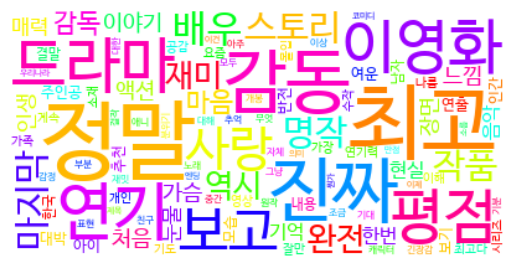

counter of okt_0: [('영화로', 483), ('관객', 591), ('작품', 1406), ('선구', 3), ('안이', 15), ('배우', 2836), ('김태희', 37), ('최대', 73), ('약점', 10), ('멘스', 19)]


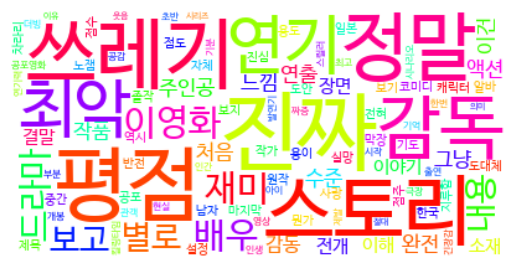

counter of mec_1: [('디자인', 21), ('학생', 97), ('외국', 59), ('디자이너', 10), ('전통', 20), ('발전', 85), ('문화', 149), ('산업', 16), ('나라', 693), ('시절', 681)]


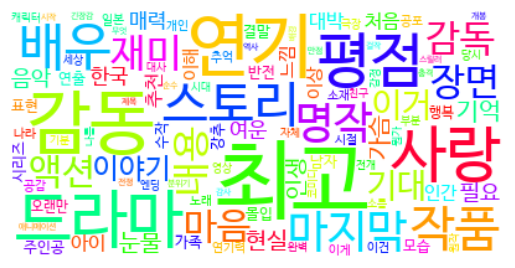

counter of mec_0: [('관객', 628), ('작품', 1489), ('선구안', 1), ('배우', 2977), ('김태희', 35), ('최대', 73), ('약점', 10), ('사극', 114), ('멘스', 19), ('이건', 2697)]


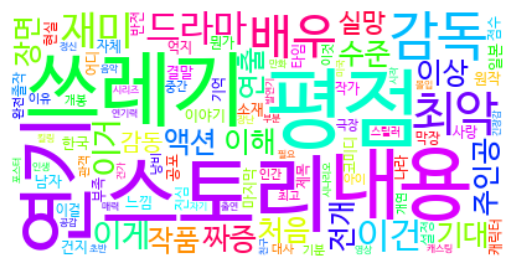

In [16]:
# 일정 thresholed_percentage 이하의 단어들만 추출 -> 지배적인 단어를 제거하기 위함
for count, tagger in zip([okt_count_1, okt_count_0, mec_count_1, mec_count_0], ['okt_1', 'okt_0', 'mec_1', 'mec_0']):
    # Get the total count of all keywords
    total_count = sum(count.values())

    # Set a threshold as a percentage of the total count
    threshold_percentage = 0.05  # You can adjust this value as needed

    # Extract the keywords that do not exceed the frequency threshold
    filtered_keywords = {keyword: count for keyword, count in count.items() if count/total_count <= threshold_percentage}
    print(f'counter of {tagger}: {list(filtered_keywords.items())[:10]}')

    wordcloud(filtered_keywords, tagger)

counter of okt_11: [('디자인', 21), ('학생', 108), ('외국', 62), ('디자이너', 10), ('일군', 1), ('전통', 19), ('통해', 243), ('발전', 83), ('문화', 107), ('산업', 11)]


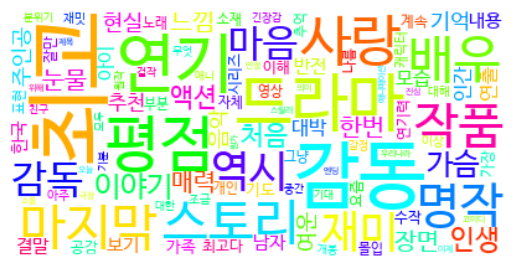

counter of okt_00: [('영화로', 483), ('관객', 591), ('작품', 1406), ('선구', 3), ('안이', 15), ('배우', 2836), ('김태희', 37), ('최대', 73), ('약점', 10), ('멘스', 19)]


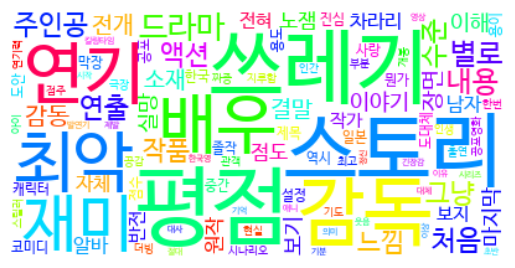

counter of mec_11: [('디자인', 21), ('학생', 97), ('외국', 59), ('디자이너', 10), ('전통', 20), ('발전', 85), ('문화', 149), ('산업', 16), ('나라', 693), ('시절', 681)]


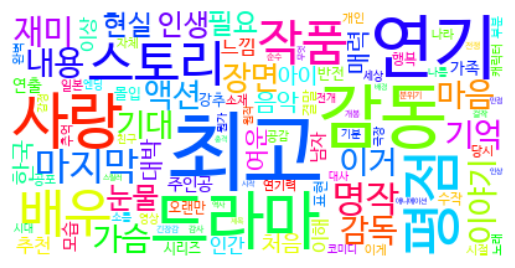

counter of mec_00: [('관객', 628), ('작품', 1489), ('선구안', 1), ('배우', 2977), ('김태희', 35), ('최대', 73), ('약점', 10), ('사극', 114), ('멘스', 19), ('유치', 400)]


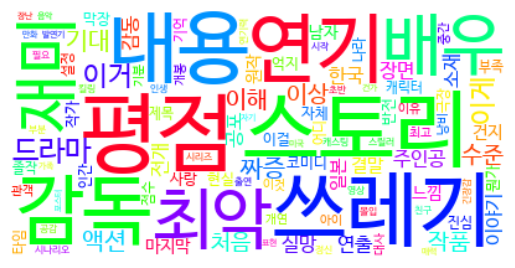

In [17]:
# wordcloud를 뽑아 본 후 눈으로 직접 지배적인 단어 및 의미없는 단어를 확인하고 제외하여 다시 워드클라우드 생성
for count, tagger in zip([okt_count_1, okt_count_0, mec_count_1, mec_count_0], ['okt_11', 'okt_00', 'mec_11', 'mec_00']):
    # Get the total count of all keywords
    total_count = sum(count.values())

    # Set a threshold as a percentage of the total count
    threshold_percentage = 0.05  # You can adjust this value as needed

    # Extract the keywords that do not exceed the frequency threshold
    filtered_keywords = {keyword: count for keyword, count in count.items() if keyword not in ['영화', '이영화', '진짜', '정말', '이건', '보고', '완전']}
    print(f'counter of {tagger}: {list(filtered_keywords.items())[:10]}')
    
    wordcloud(filtered_keywords, tagger)

---

## 워드임베딩 모델 비교

1. Word2Vec
2. FastText

### 1. Word2Vec
a. Okt  
b. Mec   

In [5]:
ratings_okt = '/home/kyuyeon/문서/kmu/23-1/bigdata-latest/movie/data/ratings-okt.csv'
ratings_mec = '/home/kyuyeon/문서/kmu/23-1/bigdata-latest/movie/data/ratings-mec.csv'

In [6]:
from gensim.models import Word2Vec

def word2vec(filepath):
    df = pd.read_csv(filepath)
    tokens = df['tokens'].apply(ast.literal_eval).tolist()
    word2vec = Word2Vec(sentences = tokens, vector_size = 128, window=5, min_count = 3, workers = 4, sg = 1)
    return word2vec

In [7]:
okt_word2vec = word2vec(ratings_okt)
mec_word2vec = word2vec(ratings_mec)

In [56]:
for tagger, w2v in zip(['okt', 'mec'], [okt_word2vec, mec_word2vec]):
    print(f'Shape of {tagger} w2v: {w2v.wv.vectors.shape}')
    print(w2v.wv.most_similar(("배우"), topn=5))
    print(w2v.wv.most_similar(("최우식"), topn=5))
    print(w2v.wv.most_similar(positive=['황정민','최우식'], negative=['별로'], topn=5))
    print(w2v.wv.most_similar(positive=['감동','마지막'], topn=5))
    print(f'----------------------------------------------------------------------------')

Shape of okt w2v: (20144, 128)
[('연기자', 0.7863320708274841), ('영화배우', 0.7627941966056824), ('김혜수', 0.7543154954910278), ('양동근', 0.75252765417099), ('아역배우', 0.7506553530693054)]
[('도조', 0.9827799797058105), ('턱턱', 0.9827117919921875), ('더맘', 0.9826177954673767), ('박정아', 0.9819898009300232), ('성무', 0.9803094267845154)]
[('김영호', 0.8438836932182312), ('경력', 0.8416728973388672), ('김갑수', 0.8407999873161316), ('백성현', 0.8398641347885132), ('이성민', 0.8371452689170837)]
[('핑', 0.7815195918083191), ('콧', 0.7763900756835938), ('피아노', 0.7758766412734985), ('글썽', 0.7712152600288391), ('주룩주룩', 0.754240095615387)]
----------------------------------------------------------------------------
Shape of mec w2v: (17659, 128)
[('연기자', 0.7869983315467834), ('조연', 0.7770618200302124), ('차승원', 0.766180694103241), ('신인', 0.764148473739624), ('손예진', 0.763884961605072)]
[('유다인', 0.9770801067352295), ('로버트패틴슨', 0.9751436114311218), ('제임스딘', 0.9744710326194763), ('제임스맥어보이', 0.9727902412414551), ('박수갈채', 0.9725962877

### 2. FastText
a. Okt  
b. Mec  

In [28]:
from gensim.models import FastText

def fasttext(filepath):
    df = pd.read_csv(filepath)
    tokens = df['tokens'].apply(ast.literal_eval).tolist()
    fasttext = FastText(sentences = tokens, vector_size = 128, window=5, min_count = 3, workers = 4, sg = 1)
    return fasttext

In [29]:
okt_fasttext = fasttext(ratings_okt)
mec_fasttext = fasttext(ratings_mec)

In [57]:
for tagger, ft in zip(['okt', 'mec'], [okt_fasttext, mec_fasttext]):
    print(f'Shape of {tagger} fasttext: {ft.wv.vectors.shape}')
    print(ft.wv.most_similar(("배우"), topn=5))
    print(ft.wv.most_similar(("최우식"), topn=5))
    print(ft.wv.most_similar(positive=['황정민','최우식'], negative=['별로'], topn=5))
    print(ft.wv.most_similar(positive=['감동','마지막'], topn=5))
    print(f'----------------------------------------------------------------------------')

Shape of okt fasttext: (20144, 128)
[('배우진', 0.7985181212425232), ('단역배우', 0.7782069444656372), ('재연배우', 0.776151180267334), ('영화배우', 0.770680844783783), ('유명배우', 0.7667515873908997)]
[('이기광', 0.9779018759727478), ('서영이', 0.9767885804176331), ('유미', 0.9742609262466431), ('류수영', 0.973111093044281), ('정아', 0.9729596376419067)]
[('상우', 0.8578376770019531), ('백성현', 0.8541812300682068), ('손현주', 0.8525455594062805), ('김영호', 0.8518030643463135), ('정려원', 0.8491257429122925)]
[('마지막모습', 0.788824200630188), ('마지막방송', 0.7867277264595032), ('핑', 0.7791186571121216), ('글썽', 0.7775189876556396), ('방울', 0.7577524781227112)]
----------------------------------------------------------------------------
Shape of mec fasttext: (17659, 128)
[('파배우', 0.8624160885810852), ('남배우', 0.8228002190589905), ('명배우', 0.8010852932929993), ('영화배우', 0.7890864014625549), ('여배우', 0.7833238840103149)]
[('대방', 0.9767491221427917), ('유다인', 0.9732888340950012), ('안소니퀸', 0.9732476472854614), ('김지미', 0.9730334281921387), ('김지호'

## visualization

In [63]:
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

rc('font', family='Noto Serif CJK JP')
mpl.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [60]:
# Get all vectors
vectors = []
for word in okt_word2vec.wv.index_to_key:
    vectors.append(okt_word2vec.wv.get_vector(word))

In [82]:
# Get some vector of the most similar words
similar_words = okt_word2vec.wv.most_similar(positive=['황정민', '마동석'], topn=50)

vectors = []
for word in similar_words:
    vectors.append(okt_word2vec.wv.get_vector(word[0]))

In [83]:
# Perform dimensionality reduction (e.g., PCA) on the vectors: 3D
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vectors)

IndexError: index 50 is out of bounds for axis 0 with size 50

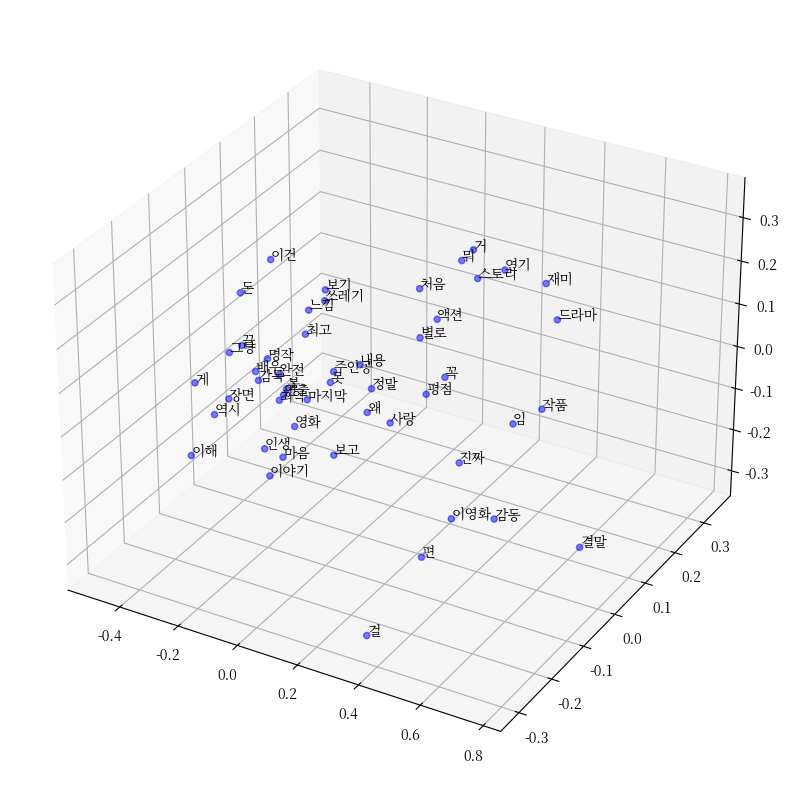

In [84]:
# Plot the word vectors in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], c='b', alpha=0.5)

for i, word in enumerate(list(okt_word2vec.wv.index_to_key)):
    ax.text(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2], word)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Word2Vec Word Embeddings')
plt.show()

In [ ]:
# Perform dimensionality reduction (e.g., PCA) on the vectors: 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

IndexError: index 50 is out of bounds for axis 0 with size 50

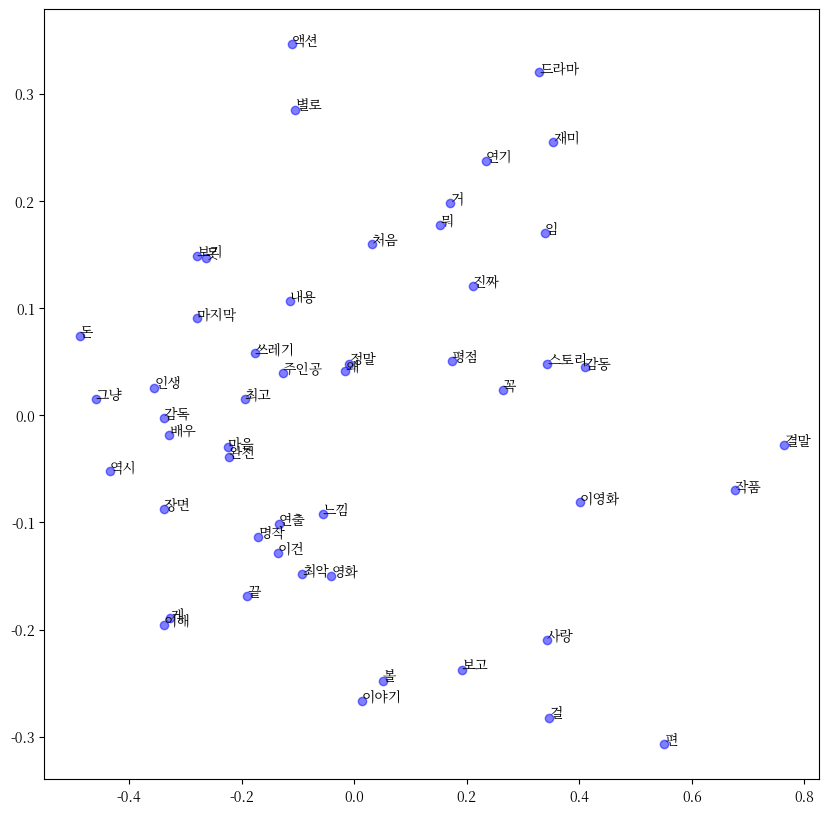

In [ ]:
# Plot the word vectors in 2D
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='b', alpha=0.5)
for i, word in enumerate(list(okt_word2vec.wv.index_to_key)):
    plt.text(vectors_2d[i, 0], vectors_2d[i, 1], word)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word2Vec Word Embeddings')
plt.savefig('/home/kyuyeon/문서/kmu/23-1/bigdata-latest/movie/embedding.png', dpi=300)
# plt.show()

---

## Modeling

In [142]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

### Modeling LSTM

In [143]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[-1])
        output = self.sigmoid(output)
        return output

### Modeling Linear Classifier

In [187]:
# Define the Linear Classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, output_size)  # 입력 차원, 출력 차원

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # 시그모이드 활성화 함수

### Dataset

In [144]:
from torch.utils.data import DataLoader, Dataset

# Define custom Dataset for train and test data
class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        # x = self.data[index]
        # y = self.labels.iloc[index]
        x = torch.tensor(self.data[index]) # 데이터를 Tensor로 변환
        y = self.labels.iloc[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [145]:
from sklearn.model_selection import train_test_split
import ast

### Sentence Vector - Simple Averaging

In [201]:
# Load and preprocess the entire dataset from a DataFrame
df = pd.read_csv('/home/kyuyeon/문서/kmu/23-1/bigdata-latest/movie/data/ratings-mec.csv') # replace with your own code to load the data from a CSV file
sentences = df['tokens'].apply(ast.literal_eval) # assuming 'tokens' is the column containing tokenized sentences, modify this according to your DataFrame

# Split the dataset into train and test sets
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, df['label'], test_size=0.2, random_state=42) # modify this line to include labels
# train_sentences, valid_sentences, train_labels, valid_labels = train_test_split(train_sentences, train_labels, test_size=0.1, random_state=42)

print(f'size of train: {len(train_sentences)}')
# print(f'size of valid: {len(valid_sentences)}')
print(f'size of test: {len(test_sentences)}')

size of train: 160000
size of test: 40000


In [215]:
# Convert tokenized sentences to word embeddings vectors
def sentence2vec(model, sentences):
    vectors = []
    for sentence in sentences:
        word_vectors = []
        for word in sentence:
            if word in model.wv.key_to_index:
                word_vectors.append(model.wv[word])
        if word_vectors:
            word_vectors = np.array(word_vectors)
            sentence_vector = np.mean(word_vectors, axis=0) # 단어 벡터들을 평균내어 문장 벡터 생성
        else:
            sentence_vector = np.array([0]*100)
        vectors.append(sentence_vector)
    vectors = np.array(vectors)
    return vectors

### Word Embedding
1. Word2Vec (CBOW)
2. Word2Vec (Skip-gram)
3. FastText

In [216]:
from gensim.models import Word2Vec

# Train Word2Vec model on the tokenized sentences
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)

train_vectors = sentence2vec(word2vec_model, train_sentences)
test_vectors = sentence2vec(word2vec_model, test_sentences)
print(train_vectors.shape) # (160000, 100)
print(train_labels.shape) # (160000,)

# Create DataLoader for train and test data
train_dataset = TextDataset(train_vectors, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False)

test_dataset = TextDataset(test_vectors, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

(160000, 100)
(160000,)


In [208]:
from gensim.models import FastText

# Train FastText model on the tokenized sentences
fasttext_model = FastText(sentences, vector_size=100, window=5, min_count=1, workers=4)
fasttext_model.train(sentences, total_examples=len(sentences), epochs=10)

train_vectors = sentence2vec(fasttext_model, train_sentences)
test_vectors = sentence2vec(fasttext_model, test_sentences)
print(train_vectors.shape) # (160000, 100)
print(train_labels.shape) # (160000,)

# Create DataLoader for train and test data
train_dataset = TextDataset(train_vectors, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False)

test_dataset = TextDataset(test_vectors, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

(160000, 100)
(160000,)


### Logistic Train, Test

In [ ]:
# Create an instance of the linear classifier model
input_size = train_vectors.shape[1]
output_size = 1 # assuming binary classification (1 or 0)
model = LinearClassifier(input_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
for epoch in tqdm(range(10)):
    model.train()
    for batch in train_loader:
        x, y = batch
        x = x.float()  # 입력 데이터를 float 형태로 변환
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

    if epoch % 1000 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, 10000, loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        x, y = batch
        x = x.float()  # 입력 데이터를 float 형태로 변환
        predictions = model(x)
        predicted_labels = (predictions > 0.5).float()
        total += y.size(0)
        correct += (predicted_labels == y.unsqueeze(1).float()).sum().item()
    accuracy = (correct / total) * 100
    print('Test Accuracy: {:.2f}%'.format(accuracy))

### LSTM Train, Test

In [175]:
input_size = 1 # word embeddings의 크기
hidden_size = 128 # LSTM의 hidden unit 개수
output_size = 1 # 출력 유닛 개수 (이진 분류)

lstm_model = LSTMModel(input_size, hidden_size, output_size) # LSTM 모델 초기화
criterion = nn.BCELoss() # BCE 손실 함수
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001) # Adam 옵티마이저

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU 사용 가능 여부에 따라 디바이스 설정
lstm_model.to(device) # 모델을 GPU로 이동

for epoch in range(10):
    for batch in train_loader:
        inputs, labels = batch
        # 데이터를 텐서로 변환하고 GPU로 이동
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).to(device)

        optimizer.zero_grad() # 그래디언트 초기화
        inputs = inputs.view(32, 100, -1)
        inputs = inputs.permute(1, 0, 2)
        # print(inputs.shape) # torch.Size([100, 32, 1])
        outputs = lstm_model(inputs) # LSTM 모델에 입력 전달
        loss = criterion(outputs.squeeze(), labels.squeeze()) # 손실 계산
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

    print('Epoch [{}/{}], Batch Loss: {:.4f}'.format(epoch + 1, 10, loss.item()))


/tmp/ipykernel_5847/294808729.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
/tmp/ipykernel_5847/294808729.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [1/10], Batch Loss: 0.6412
Epoch [2/10], Batch Loss: 0.5951
Epoch [3/10], Batch Loss: 0.6103
Epoch [4/10], Batch Loss: 0.4543
Epoch [5/10], Batch Loss: 0.7007
Epoch [6/10], Batch Loss: 0.5084
Epoch [7/10], Batch Loss: 0.4986
Epoch [8/10], Batch Loss: 0.5381
Epoch [9/10], Batch Loss: 0.5535
Epoch [10/10], Batch Loss: 0.7661


In [176]:
lstm_model.eval() # 모델을 평가 모드로 변경
test_loss = 0 # 테스트 손실 초기화
correct = 0 # 정확한 예측 개수 초기화

with torch.no_grad(): # 그래디언트 계산 비활성화
    for batch in test_loader:
        inputs, labels = batch
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).to(device)

        inputs = inputs.view(32, 100, -1)
        inputs = inputs.permute(1, 0, 2)
        outputs = lstm_model(inputs) # LSTM 모델에 입력 전달
        test_loss += criterion(outputs.squeeze(), labels.squeeze()).item() # 테스트 손실 누적 계산

        predicted = torch.round(outputs.squeeze()) # 예측값을 0 또는 1로 변환
        correct += (predicted == labels.squeeze()).sum().item() # 정확한 예측 개수 누적 계산

test_loss /= len(test_loader) # 배치 수로 나누어 평균 테스트 손실 계산
accuracy = correct / (len(test_loader) * 32) # 전체 예측 개수로 나누어 정확도 계산

print('Test Loss: {:.4f}, Accuracy: {:.2%}'.format(test_loss, accuracy))

/tmp/ipykernel_5847/594539514.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
/tmp/ipykernel_5847/594539514.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).to(device)


Test Loss: 0.5258, Accuracy: 72.67%
